## Models & Forecastiong

In [ ]:
import numpy as np  
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  
# import plotly.plotly as py # visualization library
from plotly.offline import init_notebook_mode, iplot  
init_notebook_mode(connected=True) 
import plotly.graph_objs as go 
import os
import warnings        
warnings.filterwarnings("ignore") 

In [ ]:
#read data
path = "/Users/reign/Downloads/store-sales-time-series-forecasting/"

oil = pd.read_csv(path + 'oil.csv')
trans = pd.read_csv(path + 'transactions.csv')
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

변수설명

oil
- date: 날짜
- dcoilwtico: daily price (변수 설명에 따르면, 이 데이터의 배경인 콜롬비아의 경제는 유가에 크게 의존하고 있다고 한다.)

train
- date: 날짜
- store_nbr: identifies the store at which the products are sold.
- family: 상품군
- sales:: 총판매량 (target)
- onpromption: gives the total number of items in a product family that were being promoted at a store at a given date. 

test
- date: 날짜(train의 마지막 날짜로부터 15일 뒤)
- 나머지, train과 동일

trans
- date: 날짜
- store_nbr: 상점 번호
- transaction: 거래 수

In [ ]:
ts1 = train.copy()
ts2 = oil.copy()
#시계열화
ts1['date'] = pd.to_datetime(ts1['date']) #시계열 입히기
ts1['day_of_week'] = ts1['date'].dt.dayofweek
ts1['month'] = ts1['date'].dt.month
ts1['year'] = ts1['date'].dt.year

In [ ]:
#Grouper #시계열이 중복된 것이 많을 때 유용하다. or 윈도우가 정해져 있을 때
def group(df, key, freq, col):
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index() #date를 인덱스가 아닌 컬럼으로 지정
    return df_grouped
    
#ts1_d = group(ts1, 'date', 'd', 'sales')
ts1_w = group(ts1, 'date', 'w', 'sales')
ts1_m = group(ts1, 'date', 'm', 'sales')
#ts1_y = group(ts1, 'date', 'y', 'sales')

In [ ]:
ts1_m

,date,mean
0,2013-01-31,186.952405
1,2013-02-28,193.581846
2,2013-03-31,206.880581
3,2013-04-30,205.639071
4,2013-05-31,209.943594
5,2013-06-30,218.655893
6,2013-07-31,203.783364
7,2013-08-31,212.479434
8,2013-09-30,220.593588
9,2013-10-31,213.164266


## 가변수 회귀
- 모든 시점의 변동을 동일하게 처리
- 더미변수 구성시 홀리데이나 특정 스파이크의 효과 파악 가능, 특정 시점의 효과를 캐치하는 것에 유리하다.

In [ ]:
#Regression
def add_time(df, key, freq, col):
    df_grouped = group(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index)) #인덱스 길이
    #column_time = df_grouped.pop('time') #pop 열 추출
    #df_grouped.insert(1, 'time', column_time) #insert 열 삽입
    return df_grouped

In [ ]:
ts1_reg = add_time(ts1, 'date', 'm', 'sales')
ts1_reg.dropna(inplace=True)

In [ ]:
from sklearn.linear_model import LinearRegression

#2차원 인풋을 넣어줄 것.
X = ts1_reg.loc[:,['time']]
y = ts1_reg.loc[:,['mean']]

regmodel = LinearRegression()
regmodel.fit(X, y)

y_pred = regmodel.predict(X)
ts1_reg['pred'] = y_pred
ts1_reg

,date,mean,time,pred
0,2013-01-31,186.952405,0,197.305591
1,2013-02-28,193.581846,1,203.171179
2,2013-03-31,206.880581,2,209.036767
3,2013-04-30,205.639071,3,214.902354
4,2013-05-31,209.943594,4,220.767942
5,2013-06-30,218.655893,5,226.633530
6,2013-07-31,203.783364,6,232.499118
7,2013-08-31,212.479434,7,238.364705
8,2013-09-30,220.593588,8,244.230293
9,2013-10-31,213.164266,9,250.095881


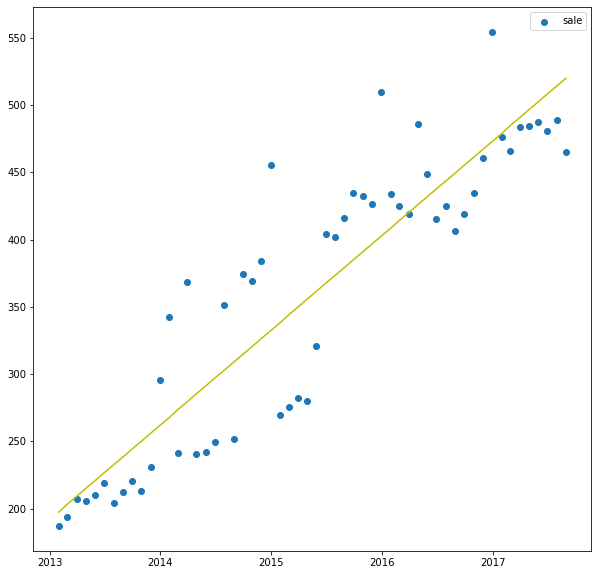

In [ ]:
plt.figure(figsize=(10,10))

plt.scatter(ts1_reg['date'],ts1_reg['mean'],label='sale')
plt.plot(ts1_reg['date'],ts1_reg['pred'],color='y')

plt.legend()
plt.show()

<AxesSubplot:ylabel='mean'>

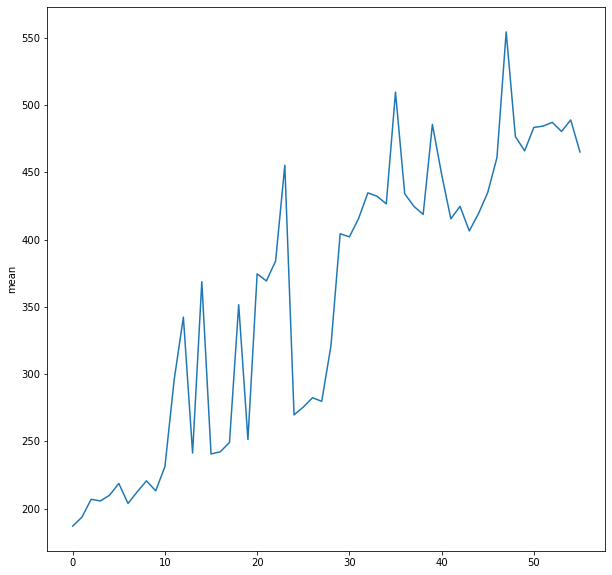

In [ ]:
plt.figure(figsize=(10,10))
sns.lineplot(ts1_m.index,ts1_m['mean'])

## ARIMA 
정상성 검정 ADF Test
- 귀무가설: 시계열 자료가 정상 시계열이 아니다.
- 대립가설: 시계열 자료가 정상 시계열다.

(p,d,q) p와 q 중 하나만 쓰는 것이 나을 때도 있다. 왜냐면 둘의 효과를 상쇄할 수 있다.

In [ ]:
#ts1_w = ts1_w.set_index('date')
#ts1_d = ts1_d.set_index('date')
#ts_diff = ts1_d - ts1_w
#ts_diff = ts_diff.dropna()

In [ ]:
#ts1_d = ts1_d.set_index('date')
#ts1_d_lag = ts1_d.shift(30)
#ts_diff = ts1_d - ts1_d_lag
#ts_diff = ts_diff.dropna()

In [ ]:
ts1_m = ts1_m.set_index('date')
ts1_m_lag = ts1_m.shift(1) #1차 차분
ts_diff = ts1_m - ts1_m_lag
ts_diff = ts_diff.dropna()
ts_diff

,mean
date,
2013-02-28,6.629441
2013-03-31,13.298735
2013-04-30,-1.241510
2013-05-31,4.304523
2013-06-30,8.712300
2013-07-31,-14.872529
2013-08-31,8.696070
2013-09-30,8.114154
2013-10-31,-7.429323


<AxesSubplot:xlabel='date', ylabel='mean'>

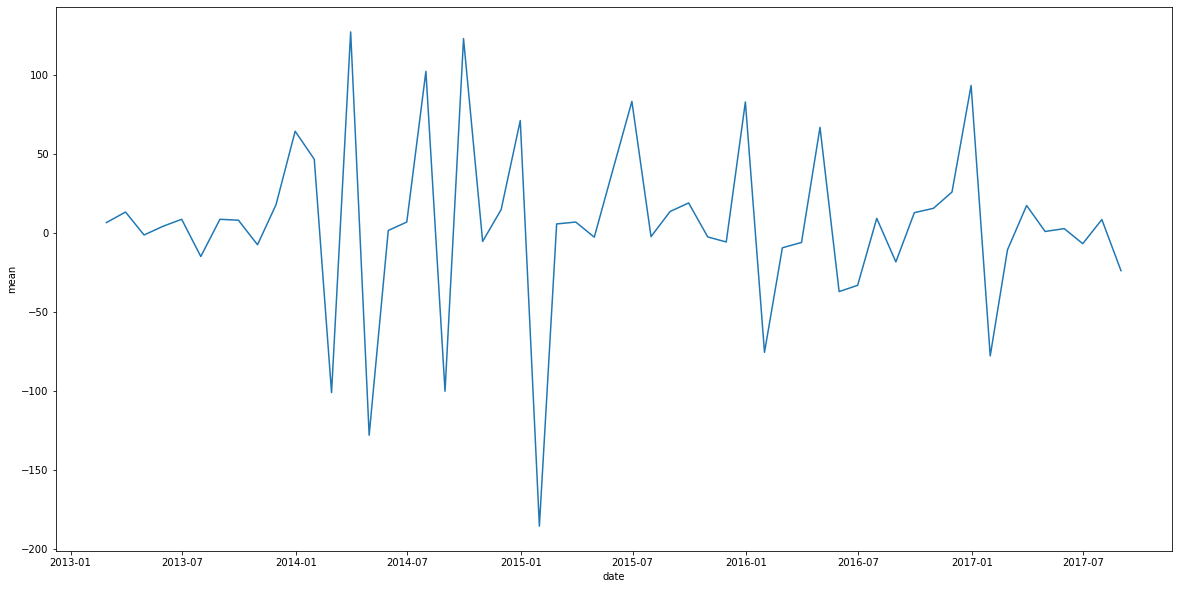

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(ts_diff.index,ts_diff['mean']) #check the spike!

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Check adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

In [ ]:
#ts1_m=ts1_m.dropna()
check_adfuller(ts1_m) #귀무가설 기각x

Test statistic:  -1.5746639319400972
p-value:  0.4963069089455666
Critical Values: {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}


In [ ]:
#but check this
check_adfuller(ts_diff) #reject H0 when the lag is 30

Test statistic:  -11.670428915143427
p-value:  1.8404561281443555e-21
Critical Values: {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}


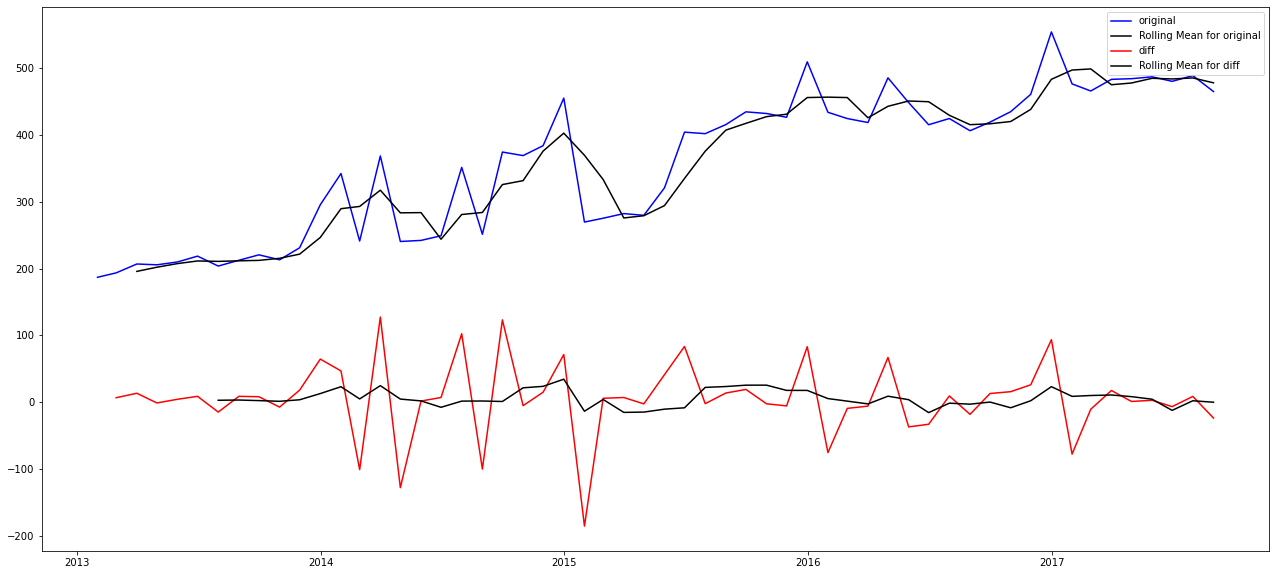

In [ ]:
rolmean = ts_diff.rolling(6).mean()
rolmean1 = ts1_m.rolling(3).mean()

plt.figure(figsize=(22,10))   
plt.plot(ts1_m,color='blue',label='original')
plt.plot(rolmean1,color='black',label='Rolling Mean for original')
plt.plot(ts_diff, color='red',label='diff')
plt.plot(rolmean, color='black', label='Rolling Mean for diff')
plt.legend()

plt.show()

### ARIMA(p,d,q) 결정

모델링시 시간은 datetime, index로 변환!

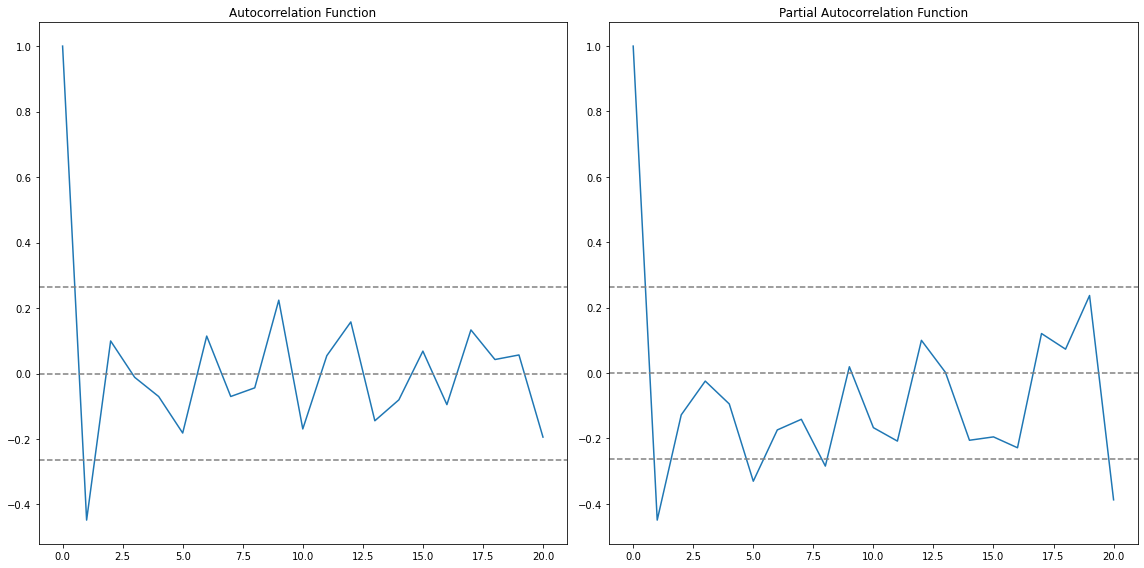

In [ ]:
# ACF and PACF 
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')
# ACF
plt.figure(figsize=(16,8))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

자기상관이 0에 가깝게 꺾이는 지점의 p와 q를 결정하자(임의가 개입되므로 벤치마크용으로만 이용하는게 좋다.)

In [ ]:
#auto arima #computing automatically

from pmdarima.arima import auto_arima
warnings.filterwarnings('ignore')
model_arima= auto_arima(ts1_m,  
                        m=12,
                       d=1,
                       D=1,
                       max_order=None,                       
                       max_p=5,
                       max_q=5,
                       max_d=2,
                       max_P=5,
                       max_Q=5,
                       max_D=5,
                       maxiter = 50,
                       alpha = 0.05,
                       n_jobs = -1,
                       seasonal=True, #sarima
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, #sarima로, 
                       stepwise=True)

model_arima.fit(ts1_m)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=499.249, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=475.368, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=488.696, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=469.085, Time=0.39 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=inf, Time=1.75 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.36 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=461.068, Time=2.94 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.48 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=463.036, Time=3.30 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=inf, Time=4.06 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=4.19 sec
 AR

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(3, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
# ARIMA LİBRARY
import statsmodels.api as sm
from pandas import datetime
# fit model
model = sm.tsa.arima.ARIMA(ts1_m, order=(1,1,0),seasonal_order=(3,1,1,12)) #모듈이 없어진듯..
result = model.fit()
forecast1 = result.predict()
print(result.summary())
#model = ARIMA(ts1_m, order=(2,0,2)) # (ARMA) = (2,0,2)
#model_fit = model.fit(disp=0)

                                     SARIMAX Results                                      
Dep. Variable:                               mean   No. Observations:                   56
Model:             ARIMA(1, 1, 0)x(3, 1, [1], 12)   Log Likelihood                -224.534
Date:                            Tue, 07 Mar 2023   AIC                            461.068
Time:                                    20:49:02   BIC                            471.635
Sample:                                01-31-2013   HQIC                           464.965
                                     - 08-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5594      0.178     -3.138      0.002      -0.909      -0.210
ar.S.L12      -1.0134      2.162   

Ljung-Box (Q) / Heteroskedasticity (H) (이분산성) / Jarque-Bera (JB)는 잔차에 대한 검정

Prob (Q) / Prob (H) / Prob (JB), 각 검정에 대한 p-value입니다. (귀무가설, 자기상관/이분산성이 없다.)

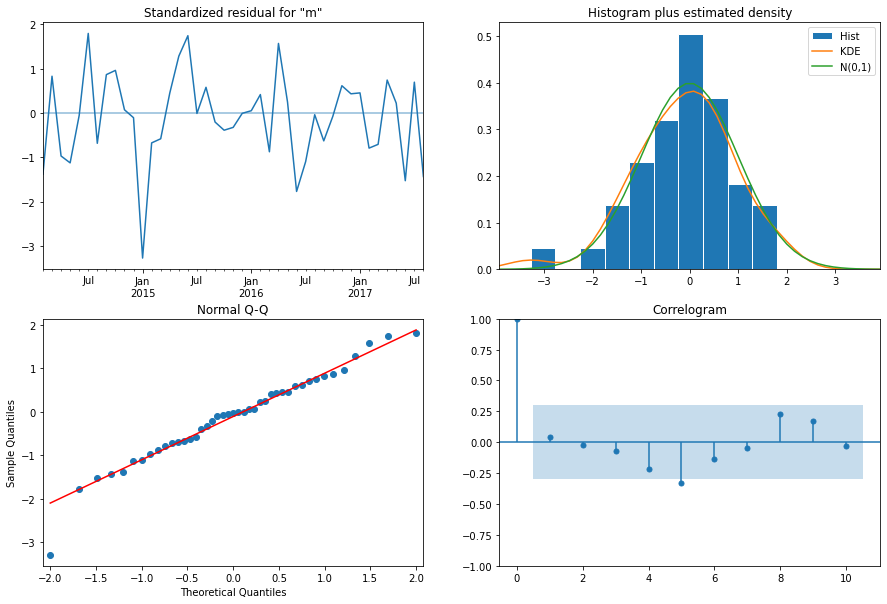

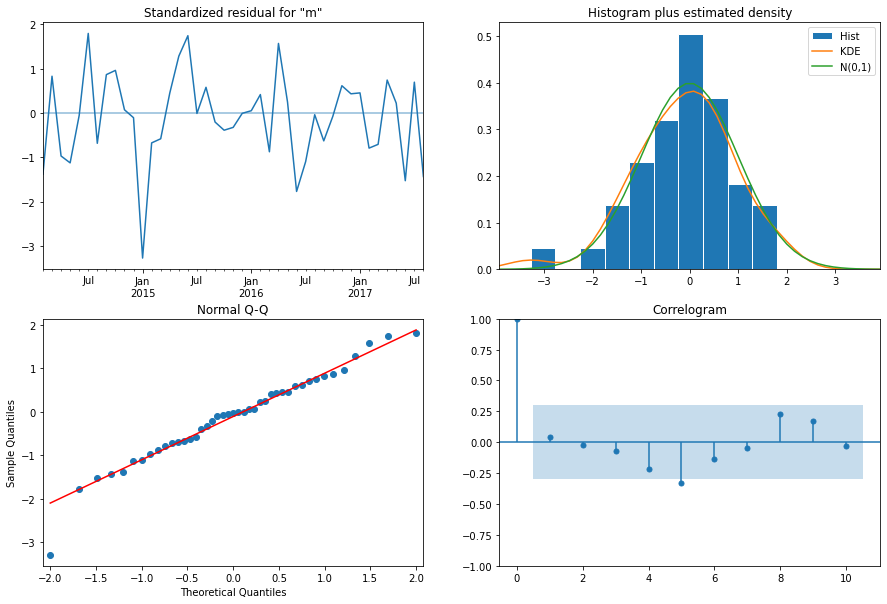

In [ ]:
result.plot_diagnostics(figsize=(15,10))

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(ts1_m, forecast1)
print("Mean Squared Error" ,error)
print("Root Mean Squared Error" ,np.sqrt(error)) 

Mean Squared Error 3155.6008856251583
Root Mean Squared Error 56.1747352964405


In [ ]:
start_index = datetime(2016, 10,31)
end_index = datetime(2017, 8,31)
forecast = result.predict(start=start_index, end=end_index) # start=start_index, end=end_index

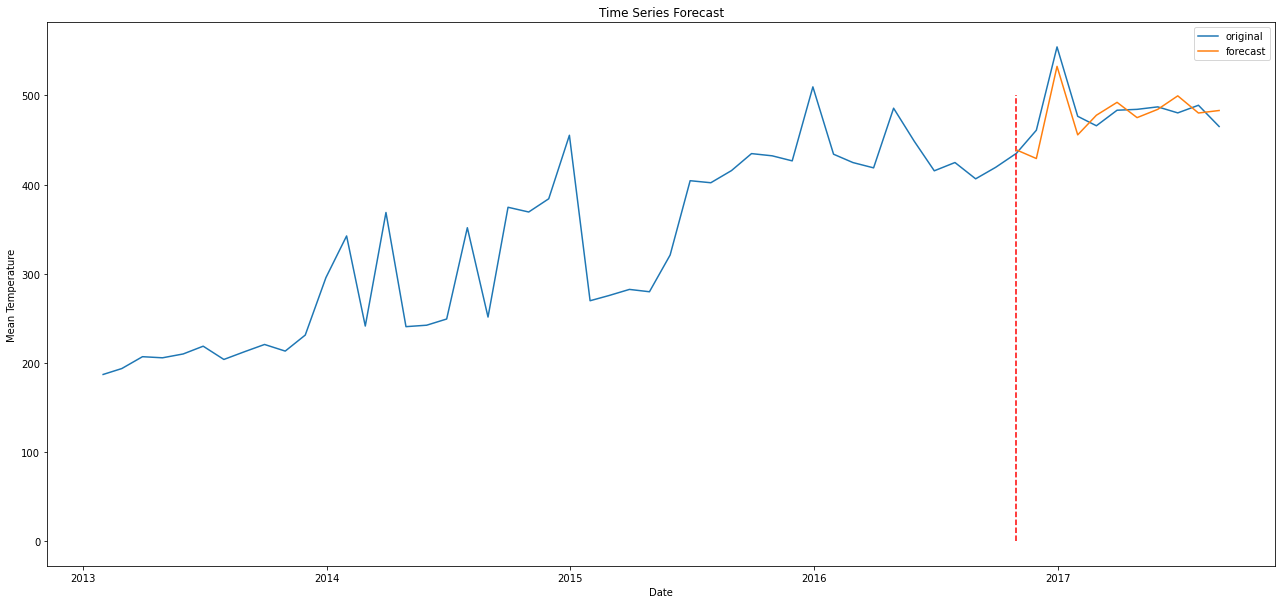

In [ ]:
# visualization
plt.figure(figsize=(22,10))
plt.plot(ts1_m.index,ts1_m['mean'], label = "original")
plt.vlines(datetime(2016,10,31), 0,500,linestyles='--', color= 'r')
plt.plot(forecast,label = "forecast")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(3, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

## VAR(백터 자기 회귀)

다변량 시계열 모델

Python `statsmodels` Datasets Package

https://www.statsmodels.org/0.6.1/datasets/index.html

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [ ]:
ts2 = oil.copy()#which is oil dataset

In [ ]:
ts2['date'] = pd.to_datetime(ts2['date'])
#check_adfuller(ts2) 
ts2 = ts2.dropna()

<AxesSubplot:xlabel='date', ylabel='dcoilwtico'>

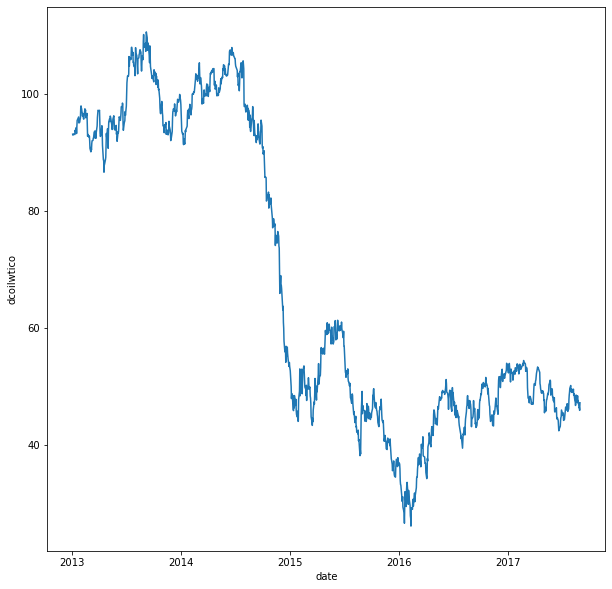

In [ ]:
plt.figure(figsize=(10,10))
sns.lineplot(ts2['date'],ts2['dcoilwtico'])

In [ ]:
#함수 재설정
def group2(df, key, freq, col):
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean_oil = (col, 'mean'))
    df_grouped = df_grouped.reset_index() #date를 인덱스가 아닌 컬럼으로 지정
    return df_grouped

In [ ]:
ts2_m = group2(ts2, 'date', 'm', 'dcoilwtico')
ts2_m

,date,mean_oil
0,2013-01-31,94.756667
1,2013-02-28,95.308947
2,2013-03-31,92.938500
3,2013-04-30,92.021364
4,2013-05-31,94.509545
5,2013-06-30,95.772500
6,2013-07-31,104.670909
7,2013-08-31,106.572727
8,2013-09-30,106.289500
9,2013-10-31,100.538261


In [ ]:
ts_conc = pd.merge(ts1_m,ts2_m,on='date', how='inner')

In [ ]:
ts_conc.rename(columns={'mean':'mean_sale'},inplace=True)
#ts_conc = ts_conc.reset_index(ts_conc['date'])
ts_conc

,date,mean_sale,mean_oil
0,2013-01-31,186.952405,94.756667
1,2013-02-28,193.581846,95.308947
2,2013-03-31,206.880581,92.938500
3,2013-04-30,205.639071,92.021364
4,2013-05-31,209.943594,94.509545
5,2013-06-30,218.655893,95.772500
6,2013-07-31,203.783364,104.670909
7,2013-08-31,212.479434,106.572727
8,2013-09-30,220.593588,106.289500
9,2013-10-31,213.164266,100.538261


<AxesSubplot:>

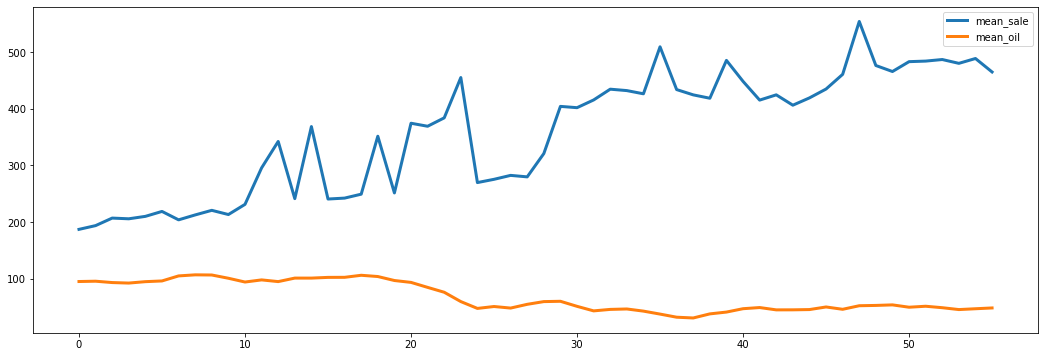

In [ ]:
ts_conc.columns
ts_conc[['mean_sale', 'mean_oil']].plot(figsize=(18, 6), linewidth=3)

In [ ]:
ts_conc.set_index('date', inplace=True)
ts_conc

,mean_sale,mean_oil
date,,
2013-01-31,186.952405,94.756667
2013-02-28,193.581846,95.308947
2013-03-31,206.880581,92.938500
2013-04-30,205.639071,92.021364
2013-05-31,209.943594,94.509545
2013-06-30,218.655893,95.772500
2013-07-31,203.783364,104.670909
2013-08-31,212.479434,106.572727
2013-09-30,220.593588,106.289500


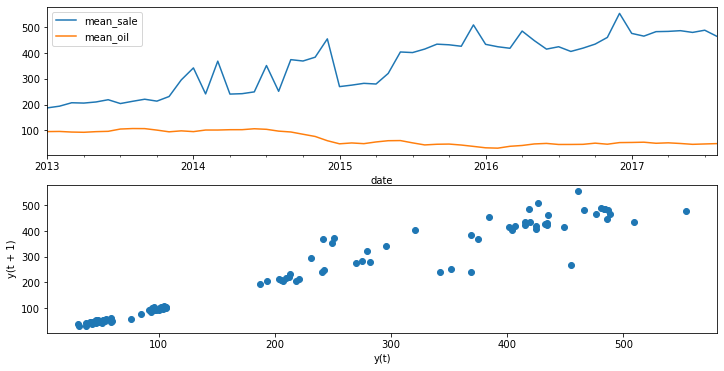

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
ts_conc.plot(ax=ax1) # series plot
pd.plotting.lag_plot(ts_conc) # lag plot # Random series does not exhibit a structure in the lag plot.
plt.show() 

In [ ]:
np.corrcoef(ts_conc['mean_oil'],ts_conc['mean_sale'])

array([[ 1.        , -0.78775945],
       [-0.78775945,  1.        ]])

In [ ]:
for i in ts_conc:
  print('--Test statistic for %s' % i)
  check_adfuller(ts_conc[i])  #H0: 비정상시계열 / H1: 비정상시계열

--Test statistic for mean_sale
Test statistic:  -1.5746639319400972
p-value:  0.4963069089455666
Critical Values: {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}
--Test statistic for mean_oil
Test statistic:  -1.2415509357760046
p-value:  0.6554711626641984
Critical Values: {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}


In [ ]:
#차분, 정상시계열화
ts_conc_d = ts_conc.diff().dropna()
ts_conc_d

,mean_sale,mean_oil
date,,
2013-02-28,6.629441,0.552281
2013-03-31,13.298735,-2.370447
2013-04-30,-1.241510,-0.917136
2013-05-31,4.304523,2.488182
2013-06-30,8.712300,1.262955
2013-07-31,-14.872529,8.898409
2013-08-31,8.696070,1.901818
2013-09-30,8.114154,-0.283227
2013-10-31,-7.429323,-5.751239


In [ ]:
for i in ts_conc_d:
  print('--Test statistic for %s' % i)
  check_adfuller(ts_conc_d[i])  #H1 채택 

--Test statistic for mean_sale
Test statistic:  -11.670428915143427
p-value:  1.8404561281443555e-21
Critical Values: {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}
--Test statistic for mean_oil
Test statistic:  -4.928361658411664
p-value:  3.070208621791548e-05
Critical Values: {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}


In [ ]:
obs = 10
X_train, X_test = ts_conc_d[0:-obs], ts_conc_d[-obs:]

print(X_train.shape)
print(X_test.shape)

(45, 2)
(10, 2)


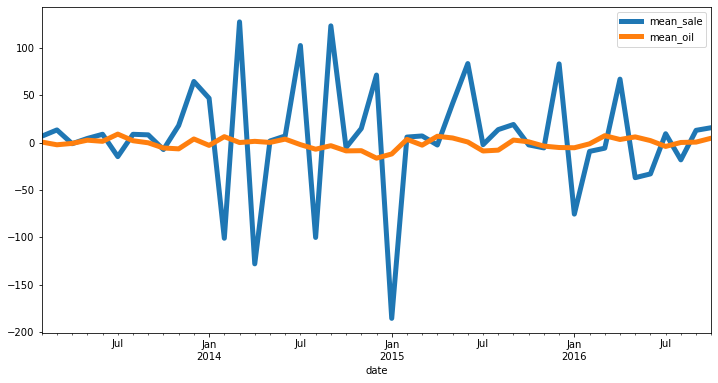

In [ ]:
X_train.plot(figsize=(12, 6), linewidth=5)
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [ ]:
model_var = VAR(endog=X_train)
res = model_var.select_order(6)
res.summary()

,AIC,BIC,FPE,HQIC
0,11.78,11.86,1.304e+05,11.81
1,11.27*,11.52*,7.812e+04*,11.36*
2,11.41,11.83,9.006e+04,11.56
3,11.48,12.07,9.721e+04,11.69
4,11.66,12.42,1.173e+05,11.93
5,11.57,12.51,1.092e+05,11.91
6,11.69,12.80,1.255e+05,12.09


In [ ]:
model_fit = model_var.fit(maxlags=1, ic='aic')
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Mar, 2023
Time:                     21:24:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.3411
Nobs:                     44.0000    HQIC:                   11.1880
Log likelihood:          -363.018    FPE:                    66052.9
AIC:                      11.0978    Det(Omega_mle):         57889.7
--------------------------------------------------------------------
Results for equation mean_sale
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               11.745854         7.893487            1.488           0.137
L1.mean_sale        -0.478866         0.130000           -3.684           0.000
L1.mean_oil          3.310567         1.436816            2.

In [ ]:
forecast2 = model_fit.forecast(X_train.values[:-10], steps=10)

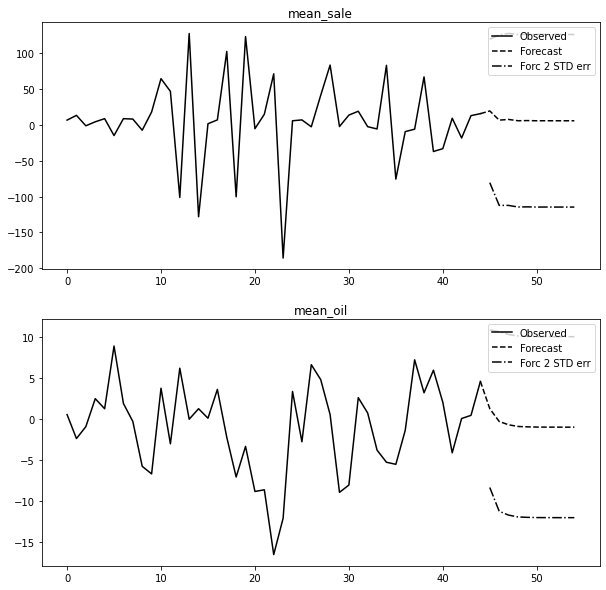

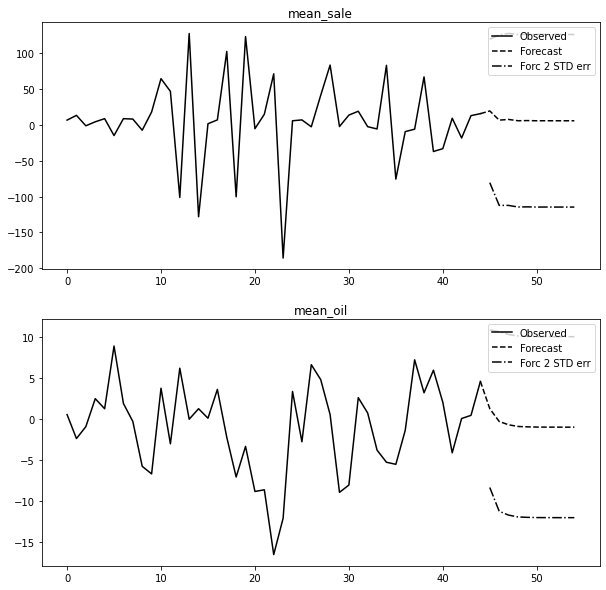

In [ ]:
model_fit.plot_forecast(10)

In [ ]:
forecast2.shape

(10, 2)

In [ ]:
error2 = mean_squared_error(X_test, forecast2)

print("Mean Squared Error" ,error2)
print("Root Mean Squared Error" ,np.sqrt(error2)) 

Mean Squared Error 908.8344756475002
Root Mean Squared Error 30.146881690276032
